In [1]:
import copy
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from utils import quantize, generate_dataset, training_algo, adding_noise_model, testing
from models_utils import MLP, Linear_noisy, Noisy_Inference
from collections import OrderedDict

# what device is the code running on?
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print( f'you are using a Mac-based GPU' )
elif torch.cuda().is_available():
    device = torch.cuda.device(0)
    print( 'You are using a '+str(torch.cuda.get_device_name(0)) )
else: 
    device = torch.device('cpu')
    print( f'you are using a: {device}' )

you are using a Mac-based GPU


In [2]:
train_loader, test_loader = generate_dataset(task='mnist')
data_loaders = [train_loader, test_loader]

### Vanilla (Standard) training

In [3]:
n_models = 5
noise_sd_list = np.array([0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3])
acc_test_vanilla = np.zeros( (n_models, len(noise_sd_list)) )
acc_test_vanilla_ref = np.zeros( n_models )

for m in range(n_models):
    model = MLP()
    data_loaders = [train_loader, test_loader]
    optimizer = torch.optim.Adam( model.parameters(), lr=1e-3 )
    model_trained, [_, _], [acc_test, loss_test] = training_algo( training_type='normal', model=model, data_loaders=data_loaders,
                                                                    optimizer=optimizer, clip_w=2.5, lr=1e-3, epochs=20, epochs_noise=2, 
                                                                    print_every=1, verbose=False, device=device )
    acc_test, _ = testing( model_trained, test_loader=test_loader, verbose=True, device=device )
    acc_test_vanilla_ref[m] = acc_test
    for n, noise_sd in enumerate(noise_sd_list):
        model_trained_noisy = adding_noise_model( model=model_trained, add_quantization=False, add_noise=True, noise_sd=noise_sd )
        acc_test_noise, _ = testing( model_trained_noisy, test_loader=test_loader, verbose=False, device=device )
        acc_test_vanilla[m, n] = acc_test_noise

In [5]:
import pickle
epochs = 20; lr = 1e-3
dict_results_vanilla = {
    'n_models' : n_models,
    'noise_sd_list' : noise_sd_list,
    'acc_test_vanilla' : acc_test_vanilla,
    'acc_test_vanilla_ref' : acc_test_vanilla_ref,
    'epochs' : epochs,
    'lr' : lr,
}

dir_save = '/Users/filippomoro/Documents/Training_with_memristors/Results/Vanilla_MNIST_MLP_new.pkl'
pickle.dump( dict_results_vanilla, open( dir_save, 'wb' ) )

### Noise in backprop phase

In [6]:
n_models = 5
noise_sd_list = np.array([0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3])
acc_test_nudging = np.zeros( (n_models, len(noise_sd_list)) )
acc_test_nudging_ref = np.zeros( n_models )
data_loaders = [train_loader, test_loader]

for m in range(n_models):
    model = MLP()
    optimizer = torch.optim.Adam( model.parameters(), lr=1e-3 )
    model_trained_nudged, _, _ = training_algo( training_type='noise_fine_tuning', model=model, data_loaders=data_loaders, 
                                                optimizer=optimizer, clip_w=2.5, lr=1e-3, epochs=20, epochs_noise=3, 
                                                print_every=1, noise_sd=1e-2, noise_every=100, verbose=False )
    acc_test, _ = testing( model_trained_nudged, test_loader=test_loader, verbose=True )
    acc_test_nudging_ref[m] = acc_test
    for n, noise_sd in enumerate( noise_sd_list ):
        model_trained_nudged_noisy = adding_noise_model( model=model_trained_nudged, add_quantization=False, add_noise=True, noise_sd=noise_sd )
        acc_test_noise, _ = testing( model_trained_nudged_noisy, test_loader=test_loader, verbose=False )
        acc_test_nudging[m, n] = acc_test_noise

-- Test accuracy 97.23% Test loss 0.0951
-- Test accuracy 97.19% Test loss 0.0951
-- Test accuracy 97.28% Test loss 0.0965
-- Test accuracy 97.21% Test loss 0.0922
-- Test accuracy 97.15% Test loss 0.0938


In [8]:
import pickle
epochs = 20; lr = 1e-3
dict_results_NoiseBack = {
    'n_models' : n_models,
    'noise_sd_list' : noise_sd_list,
    'acc_test_nudging' : acc_test_nudging,
    'acc_test_nudging_ref' : acc_test_nudging_ref,
    'epochs' : epochs,
    'lr' : lr,
}

dir_save = '/Users/filippomoro/Documents/Training_with_memristors/Results/NoiseBack_MNIST_MLP_new.pkl'
pickle.dump( dict_results_NoiseBack, open( dir_save, 'wb' ) )

### Noise in Forward phase only

In [9]:
n_models = 5
noise_sd_list = np.array([0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3])
acc_test_fon = np.zeros( (n_models, len(noise_sd_list)) )
acc_test_fon_ref = np.zeros( n_models )

for m in range(n_models):
    model = MLP(noise_inference=True, noise_sd=0.2)
    data_loaders = [train_loader, test_loader]
    optimizer = torch.optim.Adam( model.parameters(), lr=1e-3 )
    model_trained, _, _ = training_algo( training_type='normal', model=model, data_loaders=data_loaders, 
                                        optimizer=optimizer, clip_w=2.5, lr=1e-3, epochs=20, epochs_noise=2, 
                                        print_every=1, verbose=False, device=device )
    # remove noise from inference
    for l in model.layers:
        # model.layers[l].remove_noise = True
        model.layers[l].noise_inference = False

    acc_test, _ = testing( model_trained, test_loader=test_loader, verbose=True, device=device )
    acc_test_fon_ref[m] = acc_test
    for n, noise_sd in enumerate(noise_sd_list):
        model_trained_noisy = adding_noise_model( model=model_trained, add_quantization=False, add_noise=True, noise_sd=noise_sd )
        acc_test_noise, _ = testing( model_trained_noisy, test_loader=test_loader, verbose=False, device=device )
        acc_test_fon[m, n] = acc_test_noise

-- Test accuracy 97.39% Test loss 0.0829
-- Test accuracy 97.47% Test loss 0.0838
-- Test accuracy 97.50% Test loss 0.0816
-- Test accuracy 97.55% Test loss 0.0818
-- Test accuracy 97.45% Test loss 0.0806


In [11]:
import pickle
epochs = 20; lr = 1e-3
dict_results_NoiseForw = {
    'n_models' : n_models,
    'noise_sd_list' : noise_sd_list,
    'acc_test_fon' : acc_test_fon,
    'acc_test_fon_ref' : acc_test_fon_ref,
    'epochs' : epochs,
    'lr' : lr,
}

dir_save = '/Users/filippomoro/Documents/Training_with_memristors/Results/NoiseForw_MNIST_MLP_new.pkl'
pickle.dump( dict_results_NoiseForw, open( dir_save, 'wb' ) )

#### Plotting the results

In [12]:
import pickle
dir_vanilla = '/Users/filippomoro/Documents/Training_with_memristors/Results/Vanilla_MNIST_MLP_new.pkl'
with open(dir_vanilla, 'rb') as file_handler:
    dict_results_vanilla = pickle.load( file_handler )
dir_NoiseBack = '/Users/filippomoro/Documents/Training_with_memristors/Results/NoiseBack_MNIST_MLP_new.pkl'
with open(dir_NoiseBack, 'rb') as file_handler:
    dict_results_NoiseBack = pickle.load( file_handler )
dir_NoiseForw = '/Users/filippomoro/Documents/Training_with_memristors/Results/NoiseForw_MNIST_MLP_new.pkl'
with open(dir_NoiseForw, 'rb') as file_handler:
    dict_results_NoiseForw = pickle.load( file_handler )

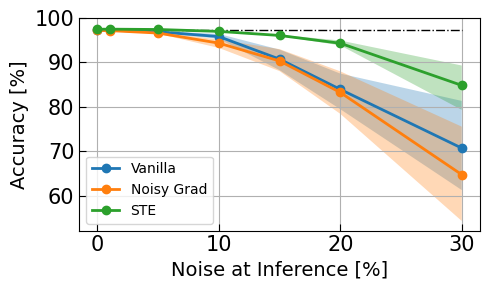

In [15]:
noise_sd_list = dict_results_vanilla['noise_sd_list']
acc_test_vanilla = 100*dict_results_vanilla['acc_test_vanilla']
acc_test_vanilla_ref = 100*dict_results_vanilla['acc_test_vanilla_ref']
acc_test_nudging = 100*dict_results_NoiseBack['acc_test_nudging']
acc_test_nudging_ref = 100*dict_results_NoiseBack['acc_test_nudging_ref']
acc_test_fon = 100*dict_results_NoiseForw['acc_test_fon']

fig, ax = plt.subplots( figsize=(5,3) )
# reference accuracy w/out noise
ax.hlines( np.mean( acc_test_vanilla_ref, axis=0 ), noise_sd_list[0]*100, noise_sd_list[-1]*100, lw=1, linestyle='-.', color='k')
# vanilla training
ax.plot( 100*noise_sd_list, np.mean( acc_test_vanilla, axis=0 ), lw=2, marker='o', ms=6, label='Vanilla')
ax.fill_between( 100*noise_sd_list, np.quantile( acc_test_vanilla, axis=0, q=0.5-0.38 ), np.quantile( acc_test_vanilla, axis=0, q=0.5+0.38 ), alpha=0.3 )
# with the noise in backward phase
ax.plot( 100*noise_sd_list, np.mean( acc_test_nudging, axis=0 ), lw=2, marker='o', ms=6, label='Noisy Grad')
ax.fill_between( 100*noise_sd_list, np.quantile( acc_test_nudging, axis=0, q=0.5-0.38 ), np.quantile( acc_test_nudging, axis=0, q=0.5+0.38 ), alpha=0.3 )
# with the noise in forward phase
ax.plot( 100*noise_sd_list, np.mean( acc_test_fon, axis=0 ), lw=2, marker='o', ms=6, label='STE')
ax.fill_between( 100*noise_sd_list, np.quantile( acc_test_fon, axis=0, q=0.5-0.38 ), np.quantile( acc_test_fon, axis=0, q=0.5+0.38 ), alpha=0.3 )
ax.tick_params( which='major', labelsize=15, direction='in', size=5 )
ax.tick_params( which='minor', direction='in', size=2.5 )
#ax.set_xscale('log')
ax.set_yticks( np.arange( 60,110,10 ) )
ax.set_xlabel('Noise at Inference [%]', size=14)
ax.set_ylabel('Accuracy [%]', size=14)
ax.grid()
ax.legend( prop={'size':10} )

## saving the plot
plt.tight_layout()
root_path_results = '/Users/filippomoro/Documents/Training_with_memristors/Results'
file_save_plot = root_path_results + '/MNIST_noise_at_inference.pdf'
fig.savefig( file_save_plot, dpi=300, transparent=True )

### Test of Forward and Backward noise training

In [ ]:
### Forward Noise
forward_noise = [0.025, 0.05, 0.1]
n_models = 5
noise_sd_list = np.array([0, 0.01, 0.02, 0.04, 0.05, 0.07, 0.1, 0.15])
acc_test_fon = np.zeros( (n_models, len(noise_sd_list)) )
acc_test_fon_ref = np.zeros( n_models )

for f, forw_noise in enumerate( forward_noise ):
    for m in range(n_models):
        model = MLP(noise_inference=True, noise_sd=forw_noise)
        data_loaders = [train_loader, test_loader]
        model_trained, _, _ = training_algo( training_type='normal', model=model, data_loaders=data_loaders, clip_w=2.5,
                                            lr=1e-3, epochs=20, epochs_noise=2, print_every=1, verbose=True, device=device )
        # remove noise from inference
        for l in model.layers:
            model.layers[l].remove_noise = True
        for n, noise_sd in enumerate(noise_sd_list):
            model_trained_noisy = adding_noise_model( model=model_trained, add_quantization=False, add_noise=True, noise_sd=noise_sd )
            acc_test_noise, _ = testing( model_trained_noisy, test_loader=test_loader, verbose=False, device=device )
            acc_test_fon[m, n, f] = acc_test_noise

In [ ]:
import pickle
epochs = 20; lr = 1e-3
dict_results_NoiseForw = {
    'forward_noise' : forward_noise,
    'n_models' : n_models,
    'noise_sd_list' : noise_sd_list,
    'acc_test_fon' : acc_test_fon,
    'acc_test_fon_ref' : acc_test_fon_ref,
    'epochs' : epochs,
    'lr' : lr,
}

dir_save = '/Users/filippomoro/Documents/Training_with_memristors/Results/NoiseForw_MNIST_MLP_analysis.pkl'
pickle.dump( dict_results_NoiseForw, open( dir_save, 'wb' ) )

In [ ]:
### Backward noise
backward_noise = [0.025, 0.05, 0.1]

n_models = 5
noise_sd_list = np.array([0, 0.01, 0.02, 0.04, 0.05, 0.07, 0.1, 0.15])
acc_test_nudging = np.zeros( (n_models, len(noise_sd_list), len(backward_noise)) )
data_loaders = [train_loader, test_loader]

for b, back_noise in enumerate( backward_noise ):
    for m in range(n_models):
        model = MLP()
        model_trained_nudged, _, _ = training_algo( training_type='noise_fine_tuning', model=model, data_loaders=data_loaders, clip_w=2.5,
                                                    lr=1e-3, epochs=20, epochs_noise=3, print_every=1, noise_sd=back_noise, noise_every=100, verbose=False )
        for n, noise_sd in enumerate( noise_sd_list ):
            model_trained_nudged_noisy = adding_noise_model( model=model_trained_nudged, add_quantization=False, add_noise=True, noise_sd=noise_sd )
            acc_test_noise, _ = testing( model_trained_nudged_noisy, test_loader=test_loader, verbose=False )
            acc_test_nudging[m, n, b] = acc_test_noise

In [ ]:
import pickle
epochs = 20; lr = 1e-3
dict_results_NoiseBack = {
    'backward_noise' : backward_noise,
    'n_models' : n_models,
    'noise_sd_list' : noise_sd_list,
    'acc_test_nudging' : acc_test_nudging,
    'epochs' : epochs,
    'lr' : lr,
}

dir_save = '/Users/filippomoro/Documents/Training_with_memristors/Results/NoiseBack_MNIST_MLP_analysis.pkl'
pickle.dump( dict_results_NoiseForw, open( dir_save, 'wb' ) )

### Test of Quantization of a weight matrix

In [5]:
def quantize( parameters, num_levels, levels=None, quantile=0.01 ):
    '''Based on an input parameter tensor (parameter), this function approximates these values to the closest available in the array <<levels>> 
    You can either specify <<levels>> explicitely or built it by default based on equally distributed <<num_levels>>.
    The <<quantile>> parameter enters in action only if <<levels>> is not defined and it sets the min and max quantized values in <<levels>>
    based on the 1-quantile and quantile values of <<parameters>> tensor
    '''
    if levels is None:
        # if levels are not specified, they assumed to be uniformely distributed and with num_levels levels
        upper_w = torch.quantile(parameters, np.clip(1-quantile, 0, 1)).item()
        lower_w = torch.quantile(parameters, np.clip(quantile, 0, 1)).item() 
        levels = torch.linspace(lower_w, upper_w, num_levels)
    # bins are built from the quantized levels, each bin defined by half the space between levels
    bins = torch.tensor( [levels[l]+torch.abs(levels[l]-levels[l+1])/2 for l in range(num_levels-1)] )
    # returning a tensor with the indeces corresponding to the bins at each entry of parameter
    idx = torch.bucketize( parameters, boundaries=bins )
    # building the quantized tensor from the quantized values (levels)
    quant_parameters = levels[idx]
    return quant_parameters

In [42]:
def adding_noise_model( model, add_quantization=True, add_noise=True, levels=np.linspace(-1,1,15), num_levels=15, noise_sd=1e-2 ):
    '''Function that takes a model with his parameters and adds noise to the parameters
    model: the original model
    add_quantization: [bool] whether to quantized the weights with num_levels levels
    add_noise: [bool] wheter to apply gaussian noise with noise_sd standard deviation'''
    with torch.no_grad():
        model_noisy = copy.deepcopy( model )
        for p in model_noisy.parameters():
            if add_quantization:
                q = quantize( p, num_levels=num_levels )
                p.copy_( q )
            if add_noise:
                delta_w = torch.abs( p.max()-p.min() )
                n = torch.randn_like( p )*(noise_sd*delta_w)
                p.copy_( p+n )
    return model_noisy

Text(0.5, 0, 'Quantile')

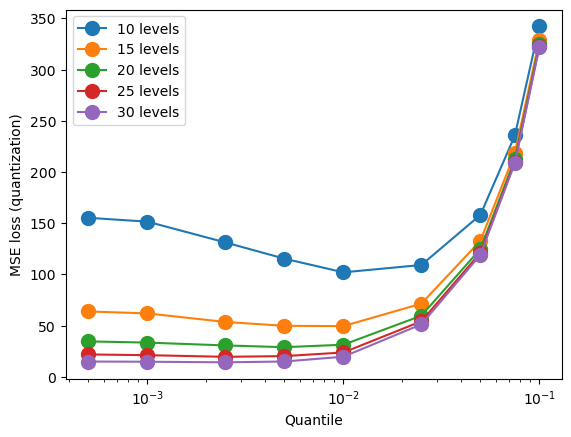

In [12]:
w = torch.randn( 256,16 )
quantiles = np.array([0.1, 0.075, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001, 0.0005])
num_levels_list = [10, 15, 20, 25, 30]
mse = np.zeros( (len(num_levels_list), len(quantiles)) )
for m, num_levels in enumerate(num_levels_list):
    for i, quant in enumerate(quantiles):
        q = quantize( w, num_levels=num_levels, quantile=quant )
        mse[m, i] = torch.pow(w - q, 2).sum()
    plt.semilogx( quantiles, mse[m], marker='o', ms=10, label=str(num_levels)+' levels' )
plt.legend()
plt.ylabel('MSE loss (quantization)')
plt.xlabel('Quantile')

# Quantization Aware Training

In [ ]:
model = MLP(noise_inference=True, noise_sd=forw_noise)

In [ ]:
noise_sd_list = np.array([0, 0.01, 0.02, 0.04, 0.05, 0.07, 0.1, 0.15]) 

In [29]:
model = MLP(  )
#model = MLP(noise_inference=True, noise_sd=1e-3)
model.generate_hidden_weights()

data_loaders = [train_loader, test_loader]
model_trained, [accs_train, losses_train], [acc_test, loss_test] = training_algo( training_type='qat_noise', model=model, data_loaders=data_loaders,
                                                                                    clip_w=2.5, lr=1e-3, epochs=10, epochs_noise=2, num_levels=4, noise_sd=1e-2,
                                                                                    print_every=1, verbose=True, device=device )

Epoch 0, Train accuracy 91.57% Test loss 0.3019
Epoch 1, Train accuracy 95.63% Test loss 0.1444
Epoch 2, Train accuracy 96.82% Test loss 0.1062
Epoch 3, Train accuracy 97.37% Test loss 0.0868
Epoch 4, Train accuracy 97.71% Test loss 0.0730
Epoch 5, Train accuracy 97.89% Test loss 0.0660
Epoch 6, Train accuracy 98.06% Test loss 0.0592
Epoch 7, Train accuracy 98.29% Test loss 0.0533
Epoch 8, Train accuracy 98.44% Test loss 0.0478
Epoch 9, Train accuracy 98.43% Test loss 0.0466
-- Test accuracy 97.22% Test loss 0.0930


QAT without noise, vs num of levels

In [57]:
# QAT with different number of levels
n_models = 3
num_levels_list = np.array([2,4,8,16,32])
acc_test_qat = np.zeros( (len(num_levels_list), n_models) )
data_loaders = [train_loader, test_loader]

for n, num_levels in enumerate(num_levels_list):
    for m in range(n_models):
        model = MLP(noise_inference=False)
        model.generate_hidden_weights()
        model_trained, _, [acc_test, _] = training_algo( training_type='qat', model=model, data_loaders=data_loaders,
                                            clip_w=2.5, lr=1e-3, epochs=15, epochs_noise=2, num_levels=num_levels,
                                            print_every=1, verbose=False, device=device )
        acc_test_qat[n, m] = acc_test
    print(f'-- QAT, Num Levels: {num_levels}, Mean Accuracy {np.mean(acc_test_qat[n])*100:.2f}%')

-- QAT, Num Levels: 2, Mean Accuracy 93.87%
-- QAT, Num Levels: 4, Mean Accuracy 96.90%
-- QAT, Num Levels: 8, Mean Accuracy 97.42%
-- QAT, Num Levels: 16, Mean Accuracy 97.62%
-- QAT, Num Levels: 32, Mean Accuracy 97.80%


In [59]:
# saving the results
import pickle
epochs = 20; lr = 1e-3
dict_results_QAT = {
    'n_models' : n_models,
    'num_levels_list' : num_levels_list,
    'acc_test_qat' : acc_test_qat,
    'epochs' : epochs,
    'lr' : lr,
}

dir_save = '/Users/filippomoro/Documents/Training_with_memristors/Results/QAT_num_levels_MNIST_MLP_analysis.pkl'
pickle.dump( dict_results_QAT, open( dir_save, 'wb' ) )

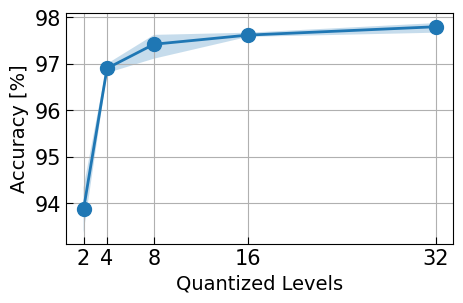

In [10]:
# Plotting QAT in num_levels VS accuracy

dir_load = '/Users/filippomoro/Documents/Training_with_memristors/Results/QAT_num_levels_MNIST_MLP_analysis.pkl'
data = pickle.load( open(dir_load, 'rb') )
num_levels_list = data['num_levels_list']
acc_test_qat = data['acc_test_qat']

fig, ax = plt.subplots( figsize=(5,3) )
ax.plot( num_levels_list, acc_test_qat.mean( axis=1 )*100, marker='o', lw=2, ms=10, label='QAT' )
ax.fill_between( num_levels_list, 100*np.quantile( acc_test_qat, q=0.05, axis=1 ), 100*np.quantile( acc_test_qat, q=0.95, axis=1 ), alpha=0.25  )
ax.tick_params( which='major', labelsize=15, direction='in', size=5 )
ax.tick_params( which='minor', direction='in', size=2.5 )
ax.set_xticks( num_levels_list )
ax.set_xlabel('Quantized Levels', size=14)
ax.set_ylabel('Accuracy [%]', size=14)
ax.grid()

In [ ]:
# QAT: Noise in Backward phase
n_models = 5
noise_sd_list = np.array([0.001, 0.0025, 0.01, 0.025, 0.05, 0.1])
acc_test_qat_back = np.zeros( (len(noise_sd_list), n_models) )
data_loaders = [train_loader, test_loader]
num_levels = 4

for n, noise_sd in enumerate(noise_sd_list):
    for m in range(n_models):
        model = MLP(noise_inference=False)
        model.generate_hidden_weights()
        model_trained, _, [acc_test, _] = training_algo( training_type='qat_noise', model=model, data_loaders=data_loaders,
                                            clip_w=2.5, lr=1e-3, epochs=10, epochs_noise=0, num_levels=num_levels,
                                            print_every=1, verbose=False, device=device )
        acc_test_qat_back[n, m] = acc_test
    print(f'QAT, noise back {noise_sd}, Test Accuracy: {acc_test_qat_back[n].mean()*100:.2f}%')

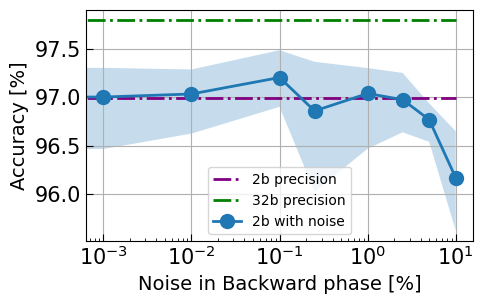

In [33]:
# Plotting QAT noise Back
dir_load = '/Users/filippomoro/Documents/Training_with_memristors/Results/QAT_back_MNIST_MLP_analysis_extended.pkl'
data = pickle.load( open(dir_load, 'rb') )
noise_sd_list = data['noise_sd_list']
acc_test_qat_back = data['acc_test_qat_back']

# load the 2 bit case w/out noise
dir_load = '/Users/filippomoro/Documents/Training_with_memristors/Results/QAT_num_levels_MNIST_MLP_analysis.pkl'
data_2b = pickle.load( open(dir_load, 'rb') )
acc_test_qat = data_2b['acc_test_qat']

fig, ax = plt.subplots( figsize=(5,3) )
# 2bit case
ax.hlines( acc_test_qat_back[0].mean( )*100, 100*noise_sd_list[0], 100*noise_sd_list[-1], color='purple', linestyles='-.', lw=2, label='2b precision' )
# 32bit case
ax.hlines( acc_test_qat[-1].mean()*100, 100*noise_sd_list[0], 100*noise_sd_list[-1], color='green', linestyles='-.', lw=2, label='32b precision' )
# noise backward
ax.plot( 100*noise_sd_list, np.mean(acc_test_qat_back, axis=1 )*100, marker='o', lw=2, ms=10, label='2b with noise' )
ax.fill_between( 100*noise_sd_list, 100*np.quantile( acc_test_qat_back, q=0.05, axis=1 ), 
                 100*np.quantile( acc_test_qat_back, q=0.95, axis=1 ), alpha=0.25  )
ax.tick_params( which='major', labelsize=15, direction='in', size=5 )
ax.tick_params( which='minor', direction='in', size=2.5 )
ax.set_xticks( 100*noise_sd_list )
ax.set_xlabel('Noise in Backward phase [%]', size=14)
ax.set_ylabel('Accuracy [%]', size=14)
ax.set_xscale('log')
ax.legend(prop={'size':10}, loc=8)
ax.grid()

In [ ]:
keys = [['0', 'O'], ['0', 'O'], ['I', 'l'], ['0', 'O']]


In [ ]:
n_models = 1
num_levels_list = np.array([2,3,5,8,12,17,32]) 
noise_sd_list = np.array([0, 0.01, 0.02, 0.04, 0.05, 0.07, 0.1, 0.15])
acc_test_qat = np.zeros( (n_models, len(num_levels_list)) )
acc_test_qat_ref = np.zeros( n_models )
data_loaders = [train_loader, test_loader]

for m in range(n_models):
    for n, num_levels in enumerate(num_levels_list):
        model = MLP(noise_inference=True)
        model.generate_hidden_weights()
        model_trained, _, _ = training_algo( training_type='qat_noise', model=model, data_loaders=data_loaders,
                                            clip_w=2.5, lr=1e-3, epochs=20, epochs_noise=2, num_levels=num_levels,
                                            print_every=1, verbose=True, device=device )
        acc_test, _ = testing( model_trained, test_loader=test_loader, verbose=True, device=device )
        acc_test_fon_ref[m] = acc_test
        for n, noise_sd in enumerate(noise_sd_list):
            model_trained_noisy = adding_noise_model( model=model_trained, add_quantization=False, add_noise=True, noise_sd=noise_sd )
            acc_test_noise, _ = testing( model_trained_noisy, test_loader=test_loader, verbose=False, device=device )
            acc_test_fon[m, n] = acc_test_noise

In [12]:
def training_algo( training_type, model, data_loaders, device='cpu', lr=1e-3, clip_w=2.5, epochs=10, epochs_noise=2, 
                   noise_sd=1e-2, noise_every=100, levels=None, num_levels=15, print_every=1, verbose=False ):

    train_loader, test_loader = data_loaders
    criterion =  torch.nn.NLLLoss() #torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam( model.parameters(), lr=lr )
    model = model.to(device)

    losses_train, accs_train = [], []
    for e in range(epochs):
        losses = []
        correct = 0
        tot_samples = 0
        for batch_idx, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            yhat = model( x )
            loss = criterion( yhat, y.long() )
            optimizer.zero_grad()
            loss.backward()

            if training_type == 'qat_noise' or training_type == 'qat':
                for p in list(model.parameters()):
                        if hasattr(p,'hid'):
                            p.data.copy_(p.hid)

            optimizer.step()
            losses.append( loss.item() )
            correct += torch.eq( torch.argmax(yhat, dim=1), y ).cpu().sum()
            tot_samples += len(y)

            if e+1 > epochs - epochs_noise and batch_idx%noise_every==0 and training_type == 'noise_fine_tuning':
                with torch.no_grad():
                    for p in model.parameters():
                        delta_w = torch.abs( p.max()-p.min() )
                        n = torch.randn_like( p )*(noise_sd*delta_w)
                        p.copy_( p+n )
            
            if clip_w is not None:
                with torch.no_grad():
                    for p in model.parameters():
                        std_w = torch.std( p )
                        p.clip_( -std_w*clip_w, +std_w*clip_w )

            if training_type == 'qat':
                for p in list(model.parameters()):  # updating the hid attribute
                    if hasattr(p,'hid'):
                        p.hid.copy_(p.data)
                    p.data = quantize( parameters=p.data, levels=levels, num_levels=num_levels )

            if training_type == 'qat_noise':
                for p in list(model.parameters()):  # updating the hid attribute
                    if hasattr(p,'hid'):
                        p.hid.copy_(p.data)
                    p.data = quantize( parameters=p.data, levels=levels, num_levels=num_levels )
                    p.data.add_( torch.randn_like(p.data)*noise_sd )

        acc_train = correct/tot_samples
        loss_train = np.mean(losses)
        if verbose and e%print_every==0:
            print( f'Epoch {e}, Train accuracy {acc_train*100:.2f}% Test loss {loss_train:.4f}' )
        accs_train.append(acc_train); losses_train.append(loss_train)

    losses = []
    correct = 0
    tot_samples = 0
    model.eval()
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        yhat = model( x )
        loss = criterion( yhat, y.long() )
        losses.append( loss.item() )
        correct += torch.eq( torch.argmax(yhat, dim=1), y ).cpu().sum()
        tot_samples += len(y)
    acc_test = correct/tot_samples
    loss_test = np.mean(losses)
    if verbose: print( f'-- Test accuracy {acc_test*100:.2f}% Test loss {loss_test:.4f}' )

    return model, [accs_train, losses_train], [acc_test, loss_test]

# RSNN

In [4]:
b, l, n = 8, 16, 4
x = torch.rand( (l, b, n) )
x = torch.where( x > 0.9, 1., 0. )

model = RSNN(in_features=4, hidden_size=6, out_features=2)
out, spk = model( x )

In [5]:
out.size()

torch.Size([8, 16, 2])

In [9]:
m, _ = torch.max(out, 1)
m.size()
torch.argmax( m, 1 ).size()

torch.Size([8])

In [2]:
class SurrGradSpike(torch.autograd.Function):    
    scale = 50.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

In [3]:
class RSNN( torch.nn.Module ):
    def __init__( self, in_features=64, hidden_size=128, out_features=20, tau_n=40e-3, tau_s=10e-3, time_stamp=1e-3,
                  noise_forward=False, mixed_precision=False, noise_sd=0.05, num_levels=15, device='cpu' ):
        super(RSNN, self).__init__()
        self.in_feature = in_features; self.hidden_size=hidden_size; self.out_features=out_features
        self.tau_n = tau_n; self.tau_s = tau_s; self.time_stamp = time_stamp
        self.alpha_n = np.exp( -time_stamp/tau_n )
        self.alpha_s = np.exp( -time_stamp/tau_s )
        self.noise_forward = noise_forward; self.mixed_precision = mixed_precision
        self.noise_sd = noise_sd; self.num_levels = num_levels
        self.device = device

        # weight placeholders
        self.w_in  = torch.nn.Parameter( torch.zeros( (hidden_size, in_features), device=device ) )
        self.w_rec = torch.nn.Parameter( torch.zeros( (hidden_size, hidden_size), device=device ) )
        self.w_out = torch.nn.Parameter( torch.zeros( (out_features, hidden_size), device=device ) )
        # initialization of the weights
        torch.nn.init.kaiming_uniform_( self.w_in  )
        torch.nn.init.kaiming_uniform_( self.w_rec )
        torch.nn.init.kaiming_uniform_( self.w_out )

    def generate_hidden_weights( self ):
        for p in self.parameters():
            p.hid = p.data.clone()

    def forward( self, x ):
        x = x.to(self.device)
        # initialize neurons and synapses
        batch_size, t_steps = x.size(1), x.size(0)
        syn = torch.zeros( ( batch_size, self.hidden_size ), device=self.device )
        mem = torch.zeros( ( batch_size, self.hidden_size ), device=self.device )
        z   = torch.zeros( ( batch_size, self.hidden_size ), device=self.device )
        sut = torch.zeros( ( batch_size, self.out_features), device=self.device )
        out = torch.zeros( ( batch_size, self.out_features), device=self.device )
        # recordings
        spk_hist, out_hist = [], []
        for t in range(t_steps):
            syn = syn + torch.mm( x[t], self.w_in.T ) + torch.mm( z, self.w_rec.T )
            syn = syn * self.alpha_s
            z = spike_fn( mem-1.0 )
            rst = z.detach()
            mem = mem - rst*mem
            #mem_hist.append(mem)
            spk_hist.append( z )
            mem = mem + syn
            mem = mem * self.alpha_n
            out = out + torch.mm( z, self.w_out.T )
            out = out * self.alpha_s
            #out = out + sut
            #out = out * self.alpha_n
            out_hist.append(out)
        spk_hist = torch.stack(spk_hist, dim=1)
        out_hist = torch.stack(out_hist, dim=1)
        #out_soft = torch.nn.functional.softmax(self.out, dim=-1)
        return out_hist, spk_hist


### Sinusoid function regression

In [89]:
def sum_of_sines_target(seq_len, n_sines=4, periods=[1000, 500, 333, 200], weights=None, phases=None, normalize=True):
    '''
    Generate a target signal as a weighted sum of sinusoids with random weights and phases.
    :param n_sines: number of sinusoids to combine
    :param periods: list of sinusoid periods
    :param weights: weight assigned the sinusoids
    :param phases: phases of the sinusoids
    :return: one dimensional vector of size seq_len contained the weighted sum of sinusoids
    '''
    if periods is None:
        periods = [np.random.uniform(low=100, high=1000) for i in range(n_sines)]
    assert n_sines == len(periods)
    sines = []
    weights = np.random.uniform(low=0.5, high=2, size=n_sines) if weights is None else weights
    phases = np.random.uniform(low=0., high=np.pi * 2, size=n_sines) if phases is None else phases
    for i in range(n_sines):
        sine = np.sin(np.linspace(0 + phases[i], np.pi * 2 * (seq_len // periods[i]) + phases[i], seq_len))
        sines.append(sine * weights[i])

    output = sum(sines)
    if normalize:
        output = output - output[0]
        scale = max(np.abs(np.min(output)), np.abs(np.max(output)))
        output = output / np.maximum(scale, 1e-6)
    return output

In [191]:
dt = 1e-3
input_f0 = 200
batch_size = 1
seq_len = 1000
n_in = 20
n_out = 1
dtype = torch.float32

# build the input pattern
# dimentions: [batch=1, time_steps=1000, neurons=1]
frozen_poisson_noise_input = np.random.rand(batch_size, seq_len, n_in) < dt * input_f0
input_spikes = torch.from_numpy(frozen_poisson_noise_input).type( dtype=dtype ).view( seq_len, batch_size, n_in )

# build the output pattern (note that the [None,:] adds an extra dimension of size 1 to the tensor)
# dimentions: [batch=1, time_steps=1000, neurons=1]
target_sinusoidal_outputs = [sum_of_sines_target(seq_len)[None, :] for i in range(n_out)]
target_sinusoidal_outputs = torch.from_numpy(np.stack(target_sinusoidal_outputs, axis=2)).type(dtype=dtype)
#target_sinusoidal_outputs = torch.from_numpy(target_sinusoidal_outputs_tf).type(dtype=dtype)

In [162]:
input_spikes.sum()

tensor(525.)

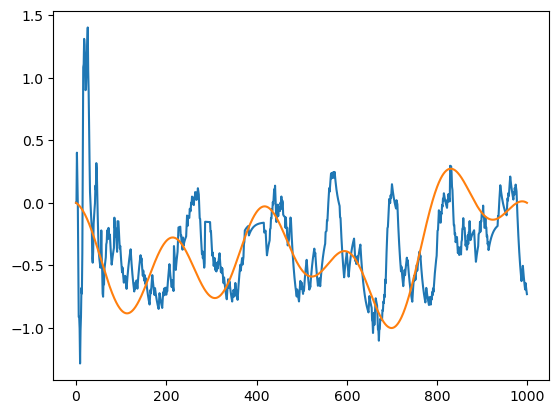

In [198]:
plt.plot( out[0].detach() )
plt.plot( target_sinusoidal_outputs[0] )

In [200]:
# learning loop
def train_loop( model, lr=5e-4, nb_epochs=200, verbose=False ):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-8, betas=(0.9,0.999))
    loss_fn = torch.nn.MSELoss()

    loss_hist = []
    for e in range(nb_epochs):
        out, _ = model(input_spikes)
        loss_val = loss_fn(out.view(batch_size,seq_len,n_out), target_sinusoidal_outputs)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        if verbose == True:
            print("Epoch %i: loss=%.5f"%(e+1,loss_val.item()))
        loss_hist.append(loss_val.item())
    return out, loss_hist

model = RSNN(in_features=n_in, hidden_size=1024, out_features=n_out)
out, loss_hist = train_loop( model, lr=5e-4, nb_epochs=500, verbose=True )

Epoch 1: loss=9.18718
Epoch 2: loss=1419.74585
Epoch 3: loss=214.88393
Epoch 4: loss=36.72205
Epoch 5: loss=233.53247
Epoch 6: loss=174.20918
Epoch 7: loss=88.31117
Epoch 8: loss=25.46090
Epoch 9: loss=7.55355
Epoch 10: loss=13.56130
Epoch 11: loss=9.83147
Epoch 12: loss=3.81925
Epoch 13: loss=1.51419
Epoch 14: loss=1.72775
Epoch 15: loss=2.26241
Epoch 16: loss=1.36628
Epoch 17: loss=0.58439
Epoch 18: loss=1.13946
Epoch 19: loss=0.91248
Epoch 20: loss=0.52985
Epoch 21: loss=0.39820
Epoch 22: loss=0.61741
Epoch 23: loss=0.63172
Epoch 24: loss=0.48649
Epoch 25: loss=0.33570
Epoch 26: loss=0.26616
Epoch 27: loss=0.30741
Epoch 28: loss=0.31202
Epoch 29: loss=0.24346
Epoch 30: loss=0.23197
Epoch 31: loss=0.21212
Epoch 32: loss=0.23740
Epoch 33: loss=0.22425
Epoch 34: loss=0.20146
Epoch 35: loss=0.18850
Epoch 36: loss=0.18227
Epoch 37: loss=0.19792
Epoch 38: loss=0.21349
Epoch 39: loss=0.19746
Epoch 40: loss=0.18245
Epoch 41: loss=0.18347
Epoch 42: loss=0.17474
Epoch 43: loss=0.19323
Epoch 4